In [2]:
# !pip install pymc arviz tqdm

In [3]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

np.random.seed(42)

## Population Simulation

In [4]:
# Define population structure
age_levels = ["18-29","30-44","45-64","65+"]
sex_levels = ["Male","Female"]
educ_levels = ["HS_or_less","Some_college","College+"]
region_levels = ["Northeast","Midwest","South","West"]

# Cross-classify all combinations
pop = pd.MultiIndex.from_product(
    [age_levels, sex_levels, educ_levels, region_levels],
    names=["age", "sex", "educ", "region"]
).to_frame(index=False)

# Random population size for each cell
rng = np.random.default_rng(2024)
pop["N_pop"] = rng.integers(5000, 30000, size=len(pop))
pop["N_pop"] = (pop["N_pop"] / pop["N_pop"].sum() * 1e7).round().astype(int)

## Define the “true” behavior (e.g., vaccination probability)

In [5]:
# True effects
age_eff  = {"18-29": -0.4, "30-44": -0.1, "45-64": 0.2, "65+": 0.6}
sex_eff  = {"Male": -0.05, "Female": 0.05}
educ_eff = {"HS_or_less": -0.5, "Some_college": 0.2, "College+": 0.6}
reg_eff  = {"Northeast": 0.2, "Midwest": 0.0, "South": -0.2, "West": 0.1}

# Generate true probabilities
logit_p = (
    -1.2
    + pop["age"].map(age_eff)
    + pop["sex"].map(sex_eff)
    + pop["educ"].map(educ_eff)
    + pop["region"].map(reg_eff)
    + rng.normal(0, 0.15, size=len(pop))
)

pop["true_p"] = 1 / (1 + np.exp(-logit_p))
true_pop_mean = np.average(pop["true_p"], weights=pop["N_pop"])
true_pop_mean

np.float64(0.2836230562873264)

In [7]:
pop.shape

(96, 6)

In [8]:
pop.head()

,age,sex,educ,region,N_pop,true_p
0,18-29,Male,HS_or_less,Northeast,67886,0.158055
1,18-29,Male,HS_or_less,Midwest,134659,0.102733
2,18-29,Male,HS_or_less,South,44946,0.074537
3,18-29,Male,HS_or_less,West,63704,0.120165
4,18-29,Male,Some_college,Northeast,79590,0.243103


## Draw a biased survey sample

In [9]:
# Expand pseudo-population
expansion_factor = (pop["N_pop"] / 1000).astype(int).clip(lower=1)
expanded = pd.concat([pop.loc[i:i] for i in pop.index.repeat(expansion_factor)], ignore_index=True)

# Biased selection probabilities
base_prob = expanded["educ"].map({
    "College+": 0.05, "Some_college": 0.02, "HS_or_less": 0.005
})
expanded["resp_prob"] = base_prob * (0.5 + 0.5 * expanded["true_p"])

# Sample respondents (~2500)
rng = np.random.default_rng(555)
expanded["selected"] = rng.binomial(1, expanded["resp_prob"])
sample = expanded.query("selected == 1").copy()

# Simulate outcome Y
sample["Y"] = rng.binomial(1, sample["true_p"])
print(f"Sample size: {len(sample)}")
print(f"Sample mean (biased): {sample['Y'].mean():.3f}")

Sample size: 186
Sample mean (biased): 0.360


## Classical post-stratification

In [10]:
# Compute sample cell means
cell_means = (
    sample.groupby(["age","sex","educ","region"])["Y"]
    .mean()
    .reset_index()
    .merge(pop[["age","sex","educ","region","N_pop"]], how="right")
    .fillna(0)
)

# Weighted population mean
classical_ps = np.average(cell_means["Y"], weights=cell_means["N_pop"])
classical_ps

np.float64(0.24518084637634063)

## Bayesian Multilevel Model (MRP)

In [11]:
# Encode categorical variables
sample_enc = sample.copy()
for col in ["age", "sex", "educ", "region"]:
    sample_enc[col] = sample_enc[col].astype("category")

coords = {
    "age": sample_enc["age"].cat.categories,
    "sex": sample_enc["sex"].cat.categories,
    "educ": sample_enc["educ"].cat.categories,
    "region": sample_enc["region"].cat.categories,
}

# Hierarchical logistic regression model
with pm.Model(coords=coords) as model:
    # Hyperpriors for random effects
    sigma_age = pm.HalfNormal("sigma_age", 1)
    sigma_sex = pm.HalfNormal("sigma_sex", 1)
    sigma_educ = pm.HalfNormal("sigma_educ", 1)
    sigma_region = pm.HalfNormal("sigma_region", 1)

    # Random intercepts
    a_age = pm.Normal("a_age", 0, sigma_age, dims="age")
    a_sex = pm.Normal("a_sex", 0, sigma_sex, dims="sex")
    a_educ = pm.Normal("a_educ", 0, sigma_educ, dims="educ")
    a_region = pm.Normal("a_region", 0, sigma_region, dims="region")

    # Intercept
    intercept = pm.Normal("intercept", 0, 1)

    # Linear predictor
    mu = (
        intercept
        + a_age[sample_enc["age"].cat.codes]
        + a_sex[sample_enc["sex"].cat.codes]
        + a_educ[sample_enc["educ"].cat.codes]
        + a_region[sample_enc["region"].cat.codes]
    )

    # Likelihood
    Y_obs = pm.Bernoulli("Y_obs", logit_p=mu, observed=sample_enc["Y"])

    # Sample posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.9, chains=4, random_seed=123)

Output()

ERROR:pymc.stats.convergence:There were 154 divergences after tuning. Increase `target_accept` or reparameterize.


In [14]:
from tqdm import tqdm
import numpy as np

# Encode categories in population data
pop_enc = pop.copy()
for col in ["age", "sex", "educ", "region"]:
    pop_enc[col] = pd.Categorical(pop_enc[col], categories=coords[col])

# Extract posterior draws and flatten across chains
posterior = trace.posterior

def flatten_param(x):
    """Flatten (chain, draw, group) -> (samples, group)"""
    x = np.array(x)
    chains, draws, *rest = x.shape
    return x.reshape(chains * draws, *rest)

intercept = flatten_param(posterior["intercept"])  # shape: (samples,)
a_age = flatten_param(posterior["a_age"])          # shape: (samples, n_age)
a_sex = flatten_param(posterior["a_sex"])          # shape: (samples, n_sex)
a_educ = flatten_param(posterior["a_educ"])        # shape: (samples, n_educ)
a_region = flatten_param(posterior["a_region"])    # shape: (samples, n_region)

posterior_samples = len(intercept)
n_cells = len(pop_enc)

# Predict for each posterior draw
posterior_probs = np.zeros((posterior_samples, n_cells))

for i in tqdm(range(posterior_samples)):
    mu_i = (
        intercept[i]
        + a_age[i, pop_enc["age"].cat.codes]
        + a_sex[i, pop_enc["sex"].cat.codes]
        + a_educ[i, pop_enc["educ"].cat.codes]
        + a_region[i, pop_enc["region"].cat.codes]
    )
    posterior_probs[i, :] = 1 / (1 + np.exp(-mu_i))

# Post-stratify by population weights
weights = pop_enc["N_pop"] / pop_enc["N_pop"].sum()
mrp_draws = posterior_probs @ weights

# Bayesian MRP estimate
mrp_mean = mrp_draws.mean()
mrp_ci = np.percentile(mrp_draws, [2.5, 97.5])

print(f"Bayesian MRP mean: {mrp_mean:.3f}")
print(f"95% Credible Interval: {mrp_ci}")

100%|██████████| 8000/8000 [00:03<00:00, 2154.63it/s]

Bayesian MRP mean: 0.331
95% Credible Interval: [0.24666171 0.41853255]


,Estimator,Estimate
0,True population,0.283623
1,Naive (sample),0.360215
2,Classical PS,0.245181
3,Bayesian MRP,0.330935


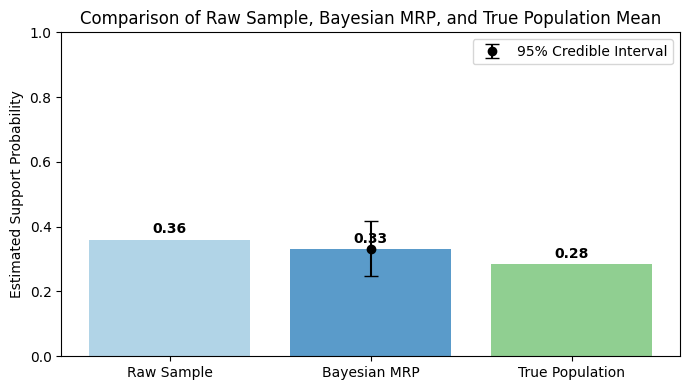

In [21]:
# --- Compute "true" population mean ---
true_mean = np.average(pop["true_p"], weights=pop["N_pop"])

# --- Compute biased sample mean ---
sample_mean = sample["Y"].mean()

# --- Plot comparison ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))

# Values and labels
estimates = [sample_mean, mrp_mean, true_mean]
labels = ["Raw Sample", "Bayesian MRP", "True Population"]

# Bars
ax.bar(labels, estimates, color=["#9ecae1", "#3182bd", "#74c476"], alpha=0.8)

# Credible interval for MRP
ax.errorbar(
    x=[1],
    y=[mrp_mean],
    yerr=[[mrp_mean - mrp_ci[0]], [mrp_ci[1] - mrp_mean]],
    fmt="o",
    color="black",
    capsize=5,
    label="95% Credible Interval",
)

# Formatting
ax.set_ylim(0, 1)
ax.set_ylabel("Estimated Support Probability")
ax.set_title("Comparison of Raw Sample, Bayesian MRP, and True Population Mean")

# Annotate bar values
for i, v in enumerate(estimates):
    ax.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=10, weight="bold")

plt.legend()
plt.tight_layout()
plt.show()

In [25]:
results = pd.DataFrame({ "Estimator": ["True population", "Naive (sample)", "Classical PS", "Bayesian MRP"], "Estimate": [true_pop_mean, sample["Y"].mean(), classical_ps, mrp_mean] })
results

,Estimator,Estimate
0,True population,0.283623
1,Naive (sample),0.360215
2,Classical PS,0.245181
3,Bayesian MRP,0.330935


/tmp/ipython-input-3900701651.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x="Estimator", y="Estimate", palette="viridis")


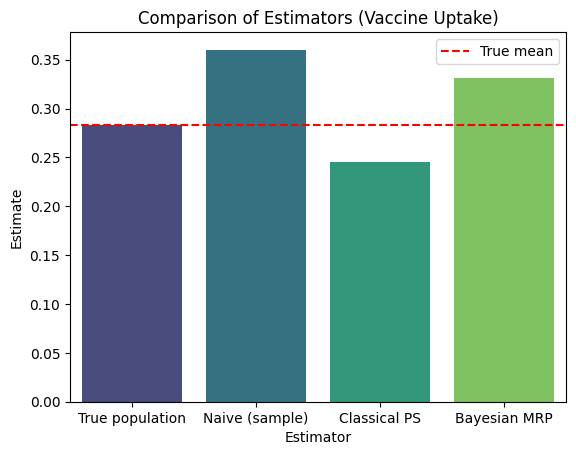

In [26]:
sns.barplot(data=results, x="Estimator", y="Estimate", palette="viridis")
plt.axhline(true_pop_mean, color="red", linestyle="--", label="True mean")
plt.title("Comparison of Estimators (Vaccine Uptake)")
plt.legend()
plt.show()